In [8]:
import pandas as pd
import re
import nltk
import random
import numpy as np
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Concatenate, Dropout, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize, sum

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df = pd.read_csv('data.csv')

df['resume_text'] = df['resume_text'].apply(clean_text)
df['job_description_text'] = df['job_description_text'].apply(clean_text)

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    df[['resume_text', 'job_description_text']], df['label'], test_size=0.2, random_state=SEED
)

max_len = 100
vectorizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=max_len)

vectorizer.adapt(pd.concat([X_train['resume_text'], X_train['job_description_text']]))

X_train_resume = vectorizer(X_train['resume_text'])
X_train_job_desc = vectorizer(X_train['job_description_text'])
X_test_resume = vectorizer(X_test['resume_text'])
X_test_job_desc = vectorizer(X_test['job_description_text'])

input_resume = Input(shape=(max_len,))
input_job_desc = Input(shape=(max_len,))

embedding_dim = 128
embedding = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_len)

encoded_resume = embedding(input_resume)
encoded_job_desc = embedding(input_job_desc)

shared_lstm = LSTM(64, return_sequences=True)

lstm_resume = shared_lstm(encoded_resume)
lstm_job_desc = shared_lstm(encoded_job_desc)

resume_pooling = Lambda(lambda x: sum(x, axis=1), output_shape=(64,))(lstm_resume)
job_desc_pooling = Lambda(lambda x: sum(x, axis=1), output_shape=(64,))(lstm_job_desc)

normalized_resume = Lambda(lambda x: l2_normalize(x, axis=1), output_shape=(64,))(resume_pooling)
normalized_job_desc = Lambda(lambda x: l2_normalize(x, axis=1), output_shape=(64,))(job_desc_pooling)

cosine_similarity = Lambda(lambda x: sum(x[0] * x[1], axis=1, keepdims=True), output_shape=(1,))([normalized_resume, normalized_job_desc])

merged = Concatenate()([normalized_resume, normalized_job_desc, cosine_similarity])
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)
dropout = Dropout(0.4)(dense)
output = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(dropout)

model = Model(inputs=[input_resume, input_job_desc], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit([X_train_resume, X_train_job_desc], y_train, epochs=15, batch_size=8, validation_split=0.2)

loss, accuracy = model.evaluate([X_test_resume, X_test_job_desc], y_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/15


e:\conda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


640/640 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5233 - loss: 1.0444 - val_accuracy: 0.5836 - val_loss: 0.8911
Epoch 2/15
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.6404 - loss: 0.8161 - val_accuracy: 0.6219 - val_loss: 0.8170
Epoch 3/15
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7246 - loss: 0.6906 - val_accuracy: 0.6539 - val_loss: 0.7652
Epoch 4/15
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7699 - loss: 0.5874 - val_accuracy: 0.7039 - val_loss: 0.7390
Epoch 5/15
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8163 - loss: 0.4992 - val_accuracy: 0.7312 - val_loss: 0.7129
Epoch 6/15
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8645 - loss: 0.4058 - val_accuracy: 0.7734 - val_loss: 0.6471
Epoch 7/15
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8925 - loss: 0.3324 - val_accuracy: 0.7891 - val_loss: 0.6511
Epoch 8/15
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9242 - loss: 0.2638 - val_accurac

In [11]:
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

Test Accuracy: 0.8287500143051147
Test Loss: 0.6381295919418335


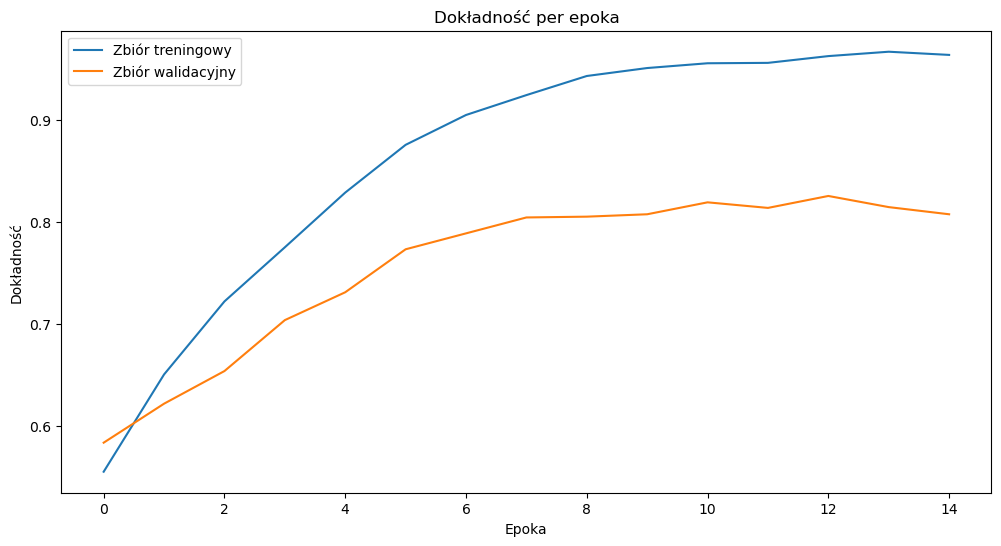

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Zbiór treningowy')
plt.plot(history.history['val_accuracy'], label='Zbiór walidacyjny')
plt.title('Dokładność per epoka')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

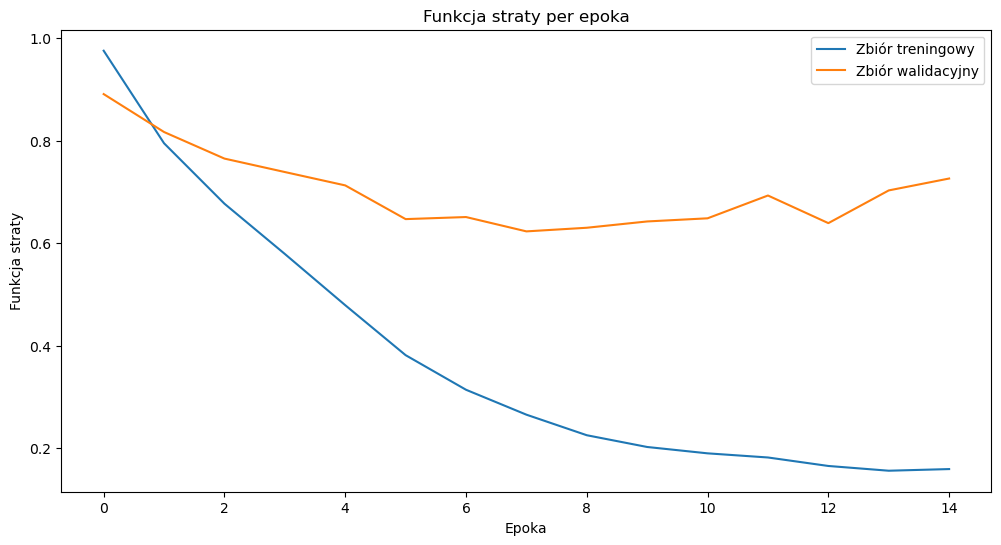

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Zbiór treningowy')
plt.plot(history.history['val_loss'], label='Zbiór walidacyjny')
plt.title('Funkcja straty per epoka')
plt.xlabel('Epoka')
plt.ylabel('Funkcja straty')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_probs = model.predict([X_test_resume, X_test_job_desc])
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate and display accuracy per class
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate and display classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

# Calculate and display Gini coefficient per class
# Gini = 2 * AUC - 1
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
gini = 2 * roc_auc - 1
print(f'Gini Coefficient: {gini}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy per class: [0.81108312 0.87701863 0.74874372]
               precision    recall  f1-score   support

     Good Fit       0.78      0.81      0.80       397
       No Fit       0.89      0.88      0.89       805
Potential Fit       0.75      0.75      0.75       398

     accuracy                           0.83      1600
    macro avg       0.81      0.81      0.81      1600
 weighted avg       0.83      0.83      0.83      1600

Gini Coefficient: 0.8620671134947013


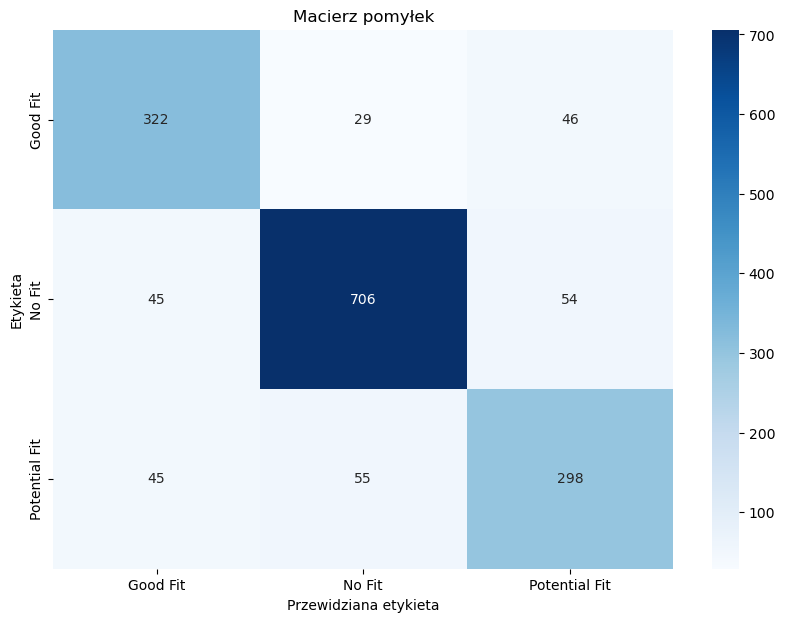

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana etykieta')
plt.ylabel('Etykieta')
plt.show()

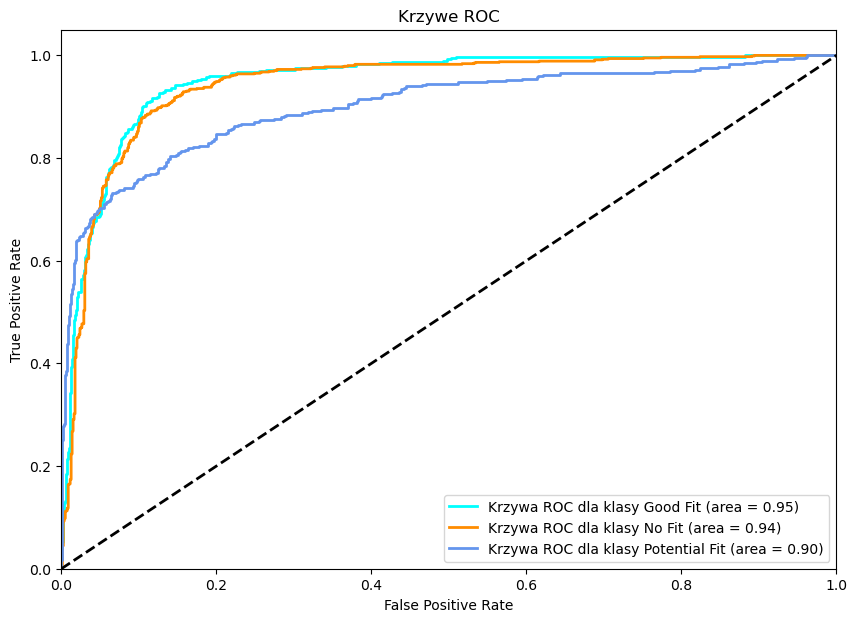

In [19]:
# Plot ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure(figsize=(10, 7))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(label_encoder.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Krzywa ROC dla klasy {label_encoder.classes_[i]} (pole = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Krzywe ROC')
plt.legend(loc="lower right")
plt.show()


In [4]:
from tensorflow.keras.utils import plot_model

model.summary()

# Assuming 'model' is your defined Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 64)   │     49,408 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64)        │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 64)        │          0 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ lambda_2[0][0],   │
│                     │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 129)       │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ lambda_3[0][0],   │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,013,771 (15.31 MB)

 Trainable params: 1,337,923 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,675,848 (10.21 MB)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [12]:
import tensorflow as tf

model.save_weights('model.keras')

input_text = tf.keras.Input(shape=(1,), dtype=tf.string)

# Apply the vectorizer to the input
vectorized_text = vectorizer(input_text)

# Create the model
vectorizer_model = Model(inputs=input_text, outputs=vectorized_text)

# Save the model
vectorizer_model.save('vectorizer.keras')

In [15]:
model.save_weights('model.weights.h5')

In [10]:
import pandas as pd
import numpy as np

y_pred_probs = model.predict([X_test_resume, X_test_job_desc])

good_fit_probs = y_pred_probs[:, 2]

X_test['good_fit_prob'] = good_fit_probs
X_test['predicted_label'] = np.argmax(y_pred_probs, axis=1)
X_test['true_label'] = y_test.values  # Add true labels

X_test_sorted = X_test.sort_values(by='good_fit_prob', ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

X_test_sorted.head(20)

40/40 [==============================] - 1s 28ms/step


,resume_text,job_description_text,good_fit_prob,predicted_label,true_label
1536,SummaryLEADERSHIP | PROCESS IMPROVEMENT & PROJ...,#Dynamics365 #ERP # Dynamics365ERP #SupplyChai...,3.601505e-08,1,1
538,SummaryHighly motivated Sales Associate with e...,We are in the process of identifying candidate...,3.594749e-08,1,1
3076,"ExperienceSystem Services Representative, Data...","The Senior Manager, Data Architecture & Data E...",3.021486e-08,1,1
181,Career OverviewOver 5 years of experience i...,Want to learn more about this role and Jobot? ...,2.849767e-08,1,1
1732,ProfileSecure a position with a well-establish...,Our client is a growing Medical Device company...,2.593029e-08,1,1
8,SummaryMore than ten years of progressive expe...,Calling all innovators find your future at Fi...,2.507060e-08,1,1
3027,Professional ProfileSeeking for a challenging ...,Purpose StatementThe Software Engineering Mana...,2.367283e-08,1,1
5765,SummaryPractical Database Engineer possessing ...,Job Description\nI am actively seeking an expe...,1.819539e-08,1,0
6046,Professional SummaryDetail-driven accounting p...,"About Allvue\nWe are Allvue Systems, the leadi...",1.751702e-08,0,0
3208,"SummaryA results driven, detail-oriented data ...","This is a W2 contract in Minneapolis, MN 55402...",1.659611e-08,0,2
